#ALMANIK BALINGGA
## email : almanik.balingga3@gmail.com

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/SANBERCODE/ADVANCE_PYTHON/week2

Mounted at /gdrive
/gdrive/My Drive/SANBERCODE/ADVANCE_PYTHON/week2


#Import Library

In [2]:
!pip install --upgrade git+https://github.com/ariaghora/mpstemmer.git
!pip install Levenshtein

  Cloning https://github.com/ariaghora/mpstemmer.git to /tmp/pip-req-build-69b8717m
  Running command git clone -q https://github.com/ariaghora/mpstemmer.git /tmp/pip-req-build-69b8717m
  Created wheel for mpstemmer: filename=mpstemmer-0.1.0-cp36-none-any.whl size=99821 sha256=f85fd4821a85c6028321941674f7d5aded4d4e8bc45247fc5eed8a830c9d074e
  Stored in directory: /tmp/pip-ephem-wheel-cache-pojqfcrx/wheels/9c/3f/58/55de6c379422be93261b1d39769b89101141d640b2dbb61563
Successfully built mpstemmer
     |████████████████████████████████| 163kB 5.7MB/s 


In [3]:
import tweepy
import pandas as pd
import numpy as np
import sqlite3

import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string
from mpstemmer import MPStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#GET DATA DAN STORE DATA KE DALAM DB
##bisa dilewati karena sudah disiapkan file db nya

In [ ]:
auth = pd.read_csv('auth.csv')

In [ ]:
cons = auth.iloc[0,0] #consumerkey
consSec = auth.iloc[1,0] #consumer secret key
token = auth.iloc[3,0] #token
tokenSec = auth.iloc[4,0] #token secret

In [ ]:
_auth = tweepy.OAuthHandler(cons, consSec)
_auth.set_access_token(token, tokenSec)
api = tweepy.API(_auth)

In [ ]:
#hilangkan tanda baca
def deletePunct(kalimat):
  return kalimat.translate(str.maketrans("","",string.punctuation))

#angka
def deleteNum(kalimat):
  return re.sub(r"\d+", "", kalimat)

#whitespace
def deleteWs(kalimat):
  return kalimat.strip()
#stopword
def delStopWord(kalimat, stop):
  tmp = kalimat.split()
  res = [kata for kata in tmp if kata not in stop]
  return res

def stemming(kalimat):
  stemmer = MPStemmer()
  stemres =[stemmer.stem(kata) for kata in kalimat]
  return ' '.join(stemres)

def normalisasi(kalimat,salah,benar):
  temp = kalimat.split()
  for i in range(len(temp)):
    idx = 0
    if temp[i] in salah:
      temp[i] = benar[salah.index(temp[i])]
  return ' '.join(temp)

#eksekusi semua + pengecilan huruf
def process(kalimat,stop,salah,benar):
  kalimat = kalimat.lower()
  temp = deleteWs(deletePunct(deleteNum(normalisasi(kalimat,salah,benar))))
  return delStopWord(temp,stop)

In [ ]:
def storeuser(id,username,nama,lokasi,tglregis,pengikut,teman,verif):
  connection = sqlite3.connect('dbtugasfix.db')
  cursor = connection.cursor()
  query = 'INSERT INTO User (userid, name, screenname, location, accountcreated, follower, friend, verified) VALUES (?,?,?,?,?,?,?,?);'
  value =(id,username,nama,lokasi,tglregis,pengikut,teman,verif)
  # try:
  #       cursor.execute(query,value)
  #       connection.commit()
  # except:
  #       print("next")
  cursor.execute(query,value)
  connection.commit()
  
  

In [ ]:
def storetweet(idtwit,idusernya,tgltwit,twit,retwit,rtfull,uname,cleantweet):
  connection = sqlite3.connect('dbtugasfix.db')
  cursor = connection.cursor()
  query = 'INSERT INTO Tweet (tweetid,userid, createddate, tweet, cleantweet,isretweet,rttext,rtuser) VALUES (?,?,?,?,?,?,?,?);'
  value = (idtwit,idusernya,tgltwit,twit,cleantweet,retwit,rtfull,uname)
  # try:
  #       cursor.execute(query,value)
  #       connection.commit()
  # except:
  #       print("next")
  cursor.execute(query,value)
  connection.commit()
  

In [ ]:
def storeData(tweet,kecuali,salah,benar):
  userid = tweet.user.id
  name = tweet.user.name
  screenname = tweet.user.screen_name
  location = tweet.user.location
  accountcreated = tweet.user.created_at
  follower = tweet.user.followers_count
  friend = tweet.user.friends_count
  if (tweet.user.verified == True):
    verified = 1
  else:
    verified = 0
  tweetid = tweet.id
  tweets = tweet.full_text
  createddate = tweet.created_at
    
    # tambahan
  x = tweet.full_text.split()
  # jika retweet maka yg diambil adalah tweet asli 
  if 'RT' in x:
    isrt = 1
    rttext = tweet.retweeted_status.full_text
    rtstatus = stemming(process(rttext,kecuali,salah,benar))
    rtuser = tweet.retweeted_status.user.name
  else:
    isrt = 0
    rtstatus = ""
    rtuser = ""
  cleantweet = stemming(process(tweets,kecuali,salah,benar))
  #store data user
  storeuser(userid,name,screenname,location,accountcreated,follower,friend,verified)
  storetweet(tweetid, userid, createddate, tweets, isrt,rtstatus,rtuser,cleantweet)

In [ ]:
def searchquery(api):
  #Judul saya adalah sertifikat tanah elektronik
  query = 'sertifikat tanah elektronik'
  max = 2000
  #menggunakan parameter lang=id untuk lebih menyaring penggunaan bahasa indonesia agar mendapat hasil stopwords maksimal
  #menggunakan cursor karena jika hanya menggunakan search terbatas 100 tweet
  searched_tweets = [status for status in tweepy.Cursor(api.search,q=query,result_type='mixed',since="2021-02-01",lang='id',tweet_mode='extended').items(max)]
  return searched_tweets

In [ ]:
kecuali = set(stopwords.words('indonesian'))
kataaman = ['tidak','kurang','sedikit','banyak','lebih']
kecuali = [kata for kata in kecuali if kata not in kataaman]

In [ ]:
mentah = searchquery(api)

In [ ]:
normal = pd.read_csv("normal.csv")

In [ ]:
#try dan except digunakan disini agar data yang masuk tiap tweet unik, sehingga 1 opini diwakili oleh 1 tweet
for i in range(len(mentah)):
  try:
    storeData(mentah[i],kecuali,list(normal['salah']),list(normal['benar']))
  except:
    continue

#Proses Anlysis Sentiment

In [9]:
connection = sqlite3.connect('dbtugasfix.db')
cursor = connection.cursor()
query = 'select * from Tweet;'
cursor.execute(query)
df =  pd.DataFrame(cursor.fetchall(), columns=['tweetid','userid','createddate', 'tweet','cleantweet','isretweet','rttext','rtuser'])
df.head()

,tweetid,userid,createddate,tweet,cleantweet,isretweet,rttext,rtuser
0,1356025762357231616,525374472,2021-01-31 23:45:10,Sertifikat tanah bakal elektronik !,sertifikat tanah elektronik,0,None,None
1,1356067321320640512,3022696022,2021-02-01 02:30:18,Sertifikat Hak Atas Tanah Elektronik tentunya ...,sertifikat hak tanah elektronik lebih aman sed...,0,None,None
2,1356480046253240320,211800482,2021-02-02 05:50:19,"Ngurus e-ktp aja belom kelar, segala pake sert...",urus ektp aja kelar pakai sertifikat tanah bik...,0,None,None
3,1356524802358472704,205630570,2021-02-02 08:48:10,RT @kompascom: Sofyan Djalil belum lama ini me...,rt kompascom sofyan djalil keluar atur menteri...,1,sofyan djalil keluar atur menteri agraria tata...,Kompas.com
4,1356552177976713216,30766806,2021-02-02 10:36:57,Ketentuan ini tertuang di pasal 16 Permen ATR ...,tentu tuang pasal permen atr nomor sertipikat ...,0,None,None


In [5]:
connection = sqlite3.connect('dbtugasfix.db')
cursor = connection.cursor()
query = 'select * from User;'
cursor.execute(query)
df2 =  pd.DataFrame(cursor.fetchall(), columns=['userid','name','screenname','location','accountcreated','follower','friend','verified'])
df2.head()

,userid,name,screenname,location,accountcreated,follower,friend,verified
0,15092519,Robert Adhi Kusumaputra,RobertAdhiKsp,Jakarta,2008-06-12 03:07:39,2361,3108,0
1,15696831,hello gugel,noorhf,"Jakarta, Indonesia",2008-08-02 01:13:35,305,398,0
2,17128975,CNN Indonesia,CNNIndonesia,None,2008-11-03 11:13:25,1561777,23,1
3,17185358,mochamad.dahlan,faisaldahlan,"bogor, jakarta, cirebon",2008-11-05 09:07:59,98,544,0
4,18129942,TEMPO.CO,tempodotco,Indonesia,2008-12-15 03:54:15,1727238,25,1


In [10]:
connection = sqlite3.connect('dbtugasfix.db')
cursor = connection.cursor()
query = """select * from Tweet
join User
on Tweet.userid = User.userid;"""
cursor.execute(query)
df3 =  pd.DataFrame(cursor.fetchall(), columns=['tweetid','userid','createddate', 'tweet','cleantweet','isretweet','rttext','rtuser','userid','name','screenname','location','accountcreated','follower','friend','verified'])
df3.head()

,tweetid,userid,createddate,tweet,cleantweet,isretweet,rttext,rtuser,userid,name,screenname,location,accountcreated,follower,friend,verified
0,1356025762357231616,525374472,2021-01-31 23:45:10,Sertifikat tanah bakal elektronik !,sertifikat tanah elektronik,0,None,None,525374472,kookie's eomma,Indah4IAM,Jakarta,2012-03-15 13:33:10,123,249,0
1,1356067321320640512,3022696022,2021-02-01 02:30:18,Sertifikat Hak Atas Tanah Elektronik tentunya ...,sertifikat hak tanah elektronik lebih aman sed...,0,None,None,3022696022,SAKUIN,sakuinformasi,Jakarta,2015-02-16 15:51:42,887,118,0
2,1356480046253240320,211800482,2021-02-02 05:50:19,"Ngurus e-ktp aja belom kelar, segala pake sert...",urus ektp aja kelar pakai sertifikat tanah bik...,0,None,None,211800482,🐥piyakpiyak🐥,zombieplekeset,None,2010-11-04 09:01:27,169,132,0
3,1356524802358472704,205630570,2021-02-02 08:48:10,RT @kompascom: Sofyan Djalil belum lama ini me...,rt kompascom sofyan djalil keluar atur menteri...,1,sofyan djalil keluar atur menteri agraria tata...,Kompas.com,205630570,fan,irfanhp,+62,2010-10-21 08:40:39,429,730,0
4,1356552177976713216,30766806,2021-02-02 10:36:57,Ketentuan ini tertuang di pasal 16 Permen ATR ...,tentu tuang pasal permen atr nomor sertipikat ...,0,None,None,30766806,Katak Pembina 走れ包,Reiza_Patters,"Tomage-Fakfak, Indonesia",2009-04-13 01:02:30,47858,3928,0


##SENTIMEN

In [11]:
kata =[]
for i in range(len(df3['tweetid'])):
  if  df3['isretweet'].iloc[i] == 1:
    kata.append(df3['rttext'].iloc[i].split())
  else:
    kata.append(df3['cleantweet'].iloc[i].split())

In [12]:
pos_list= open("./positif.txt","r")
pos_kata = pos_list.readlines()
neg_list= open("./negatif.txt","r")
neg_kata = neg_list.readlines()

In [13]:
pos_kata = [x[:-1] for x in pos_kata]
neg_kata = [x[:-1] for x in neg_kata]

In [14]:
pos_kata = list(set(pos_kata))
neg_kata = list(set(neg_kata))

In [15]:
globalsent = []
label =[]
for item in kata:
  count_p = 0
  count_n = 0
  for kata_pos in pos_kata:
    if kata_pos.strip() in item:
      count_p +=1
  for kata_neg in neg_kata:
    if kata_neg.strip() in item:
      count_n +=1
  tmp = count_p - count_n
  if tmp > 0:
    label.append(1)
  elif tmp < 0:
    label.append(-1)
  else:
    label.append(0)
  globalsent.append(tmp)

In [36]:
sentiment =pd.DataFrame({'tweetid':df3['tweetid'],'sentiment':label})
sentiment.head()

,tweetid,sentiment
0,1356025762357231616,0
1,1356067321320640512,0
2,1356480046253240320,0
3,1356524802358472704,-1
4,1356552177976713216,-1


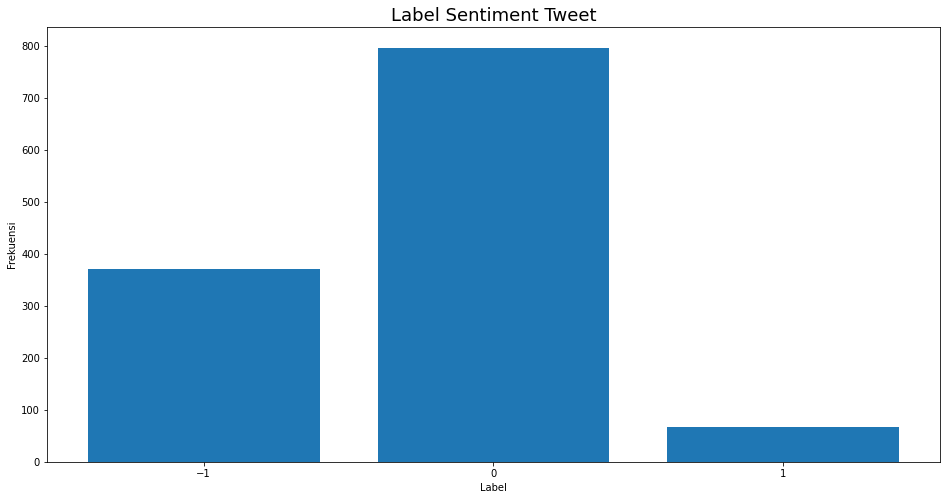

[-1  0  1]
[371 797  67]


In [16]:
import matplotlib.pyplot as plt
labels, counts = np.unique(label, return_counts=True)
fig, ax = plt.subplots(figsize=(16,8))
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel("Frekuensi")
plt.xlabel("Label")
plt.title("Label Sentiment Tweet", fontsize=18)
plt.show()
print(labels)
print(counts)

In [17]:
labels

array([-1,  0,  1])

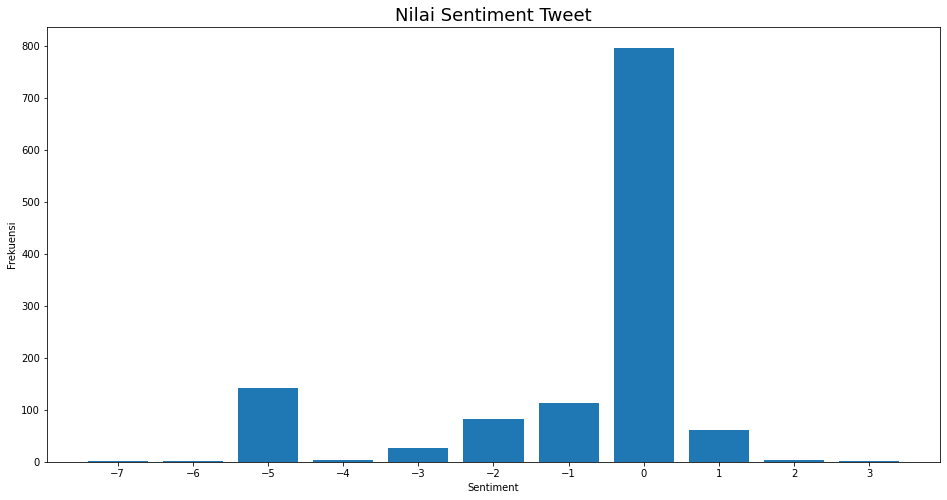

[-7 -6 -5 -4 -3 -2 -1  0  1  2  3]
[  1   1 142   4  27  82 114 797  62   4   1]


In [18]:
import matplotlib.pyplot as plt
labels, counts = np.unique(globalsent, return_counts=True)
fig, ax = plt.subplots(figsize=(16,8))
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel("Frekuensi")
plt.xlabel("Sentiment")
plt.title("Nilai Sentiment Tweet", fontsize=18)
plt.show()
print(labels)
print(counts)


##RT TERBANYAK

In [39]:
connection = sqlite3.connect('dbtugasfix.db')
cursor = connection.cursor()
query = """select Tweet.userid, User.name,Tweet.rtuser from Tweet
join User
on Tweet.userid = User.userid
where Tweet.isretweet = 1;"""
cursor.execute(query)
df55 =  pd.DataFrame(cursor.fetchall(), columns=['userid','name','rtuser'])

In [40]:
user = list(df55['name'])
rt_user = list(df55['rtuser'])

In [42]:
labels, counts = np.unique(rt_user, return_counts=True)
# plt.bar(labels, counts, align='center')
# plt.gca().set_xticks(labels)
# plt.show()
terbanyak = pd.DataFrame({'user':labels,'counts':counts})
terbanyak = terbanyak.sort_values(by=['counts'], ascending=False)
terbanyak.iloc[:10]

,user,counts
35,Ronnie H. Rusli. MS. PhD.,259
24,Kompas.com,199
19,IG : Nicho Silalahi. YT : Migran TV,141
9,CNN Indonesia,78
11,DetikFinance,47
41,Tribunnews,41
44,detikcom,25
25,Liputan6.com,18
49,𝐑𝐨𝐦𝐳,16
2,Arries,16


In [43]:
tuit =[]
connection = sqlite3.connect('dbtugasfix.db')
cursor = connection.cursor()
query = """select User.name,Tweet.tweet from tweet
join User
ON Tweet.userid = User.userid
where User.name = "Ronnie H. Rusli. MS. PhD.";"""
cursor.execute(query)
tuit.append(cursor.fetchall())
query = """select User.name,Tweet.tweet from tweet
join User
ON Tweet.userid = User.userid
where User.name = "Kompas.com";"""
cursor.execute(query)
tuit.append(cursor.fetchall())

query = """select User.name,Tweet.tweet from tweet
join User
ON Tweet.userid = User.userid
where User.name = "IG : Nicho Silalahi. YT : Migran TV";"""
cursor.execute(query)
tuit.append(cursor.fetchall())


query = """select User.name,Tweet.tweet from tweet
join User
ON Tweet.userid = User.userid
where User.name = "CNN Indonesia";"""
cursor.execute(query)
tuit.append(cursor.fetchall())


query = """select User.name,Tweet.tweet from tweet
join User
ON Tweet.userid = User.userid
where User.name = "DetikFinance";"""
cursor.execute(query)
tuit.append(cursor.fetchall())
for i in range(5):
  print("Tweet : ",tuit[i][0][1],"\n oleh : ",tuit[i][0][0])

Tweet :  Akibat SHM elektronik yg baru dari BPN dengan yg tercetak di kertas surat SHM lama, nomor, luas tanah, tahun dan lokasi dari sertifikat tanah sama, tetapi nama pemilik berbeda dan sudah pindah tangan. Jadi masalah hukum apalagi sdh diperjual belikan. Mantab lah negara ini 
 oleh :  Ronnie H. Rusli. MS. PhD.
Tweet :  "BPN tidak akan pernah menarik sertifikat. Kalau ada orang mengaku dari BPN ingin menarik sertifikat, jangan dilayani," tegas Menteri Sofyan. https://t.co/Q52HiRhYHB 
 oleh :  Kompas.com
Tweet :  K0NT0LAH.!

Ketika model elektronik maka akan rentan di hack atau dihapus dari database itu sertifikat, sehingga mafia tanah Semangkin mudah merampas hak rakyat, Patut diduga Demi proyek habisi anggaran sekaligus memudahkan penghapusan bukti² sah kepemilikan tanah secara verbal. https://t.co/cVUobdoIXK 
 oleh :  IG : Nicho Silalahi. YT : Migran TV
Tweet :  'Mengasah' Konflik Agraria dengan Sertifikat Tanah Elektronik https://t.co/alTFcnL1aV 
 oleh :  CNN Indonesia
Tweet : 

In [19]:
hari = list(df3['createddate'])

In [20]:
hari[0][:10]

'2021-01-31'

In [21]:
seminggu = [x[:10] for x in hari]

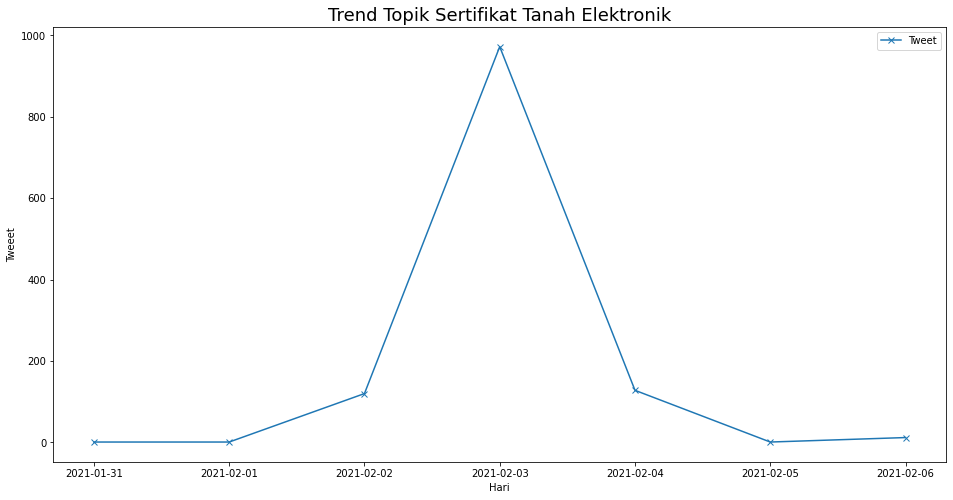

['2021-01-31' '2021-02-01' '2021-02-02' '2021-02-03' '2021-02-04'
 '2021-02-05' '2021-02-06']
[  1   1 120 972 128   1  12]


In [23]:
labels, counts = np.unique(seminggu, return_counts=True)

fig, ax = plt.subplots(figsize=(16,8))
plt.plot(labels, counts, marker="x", label = "Tweet")
plt.gca().set_xticks(labels)
plt.ylabel("Tweeet")
plt.xlabel("Hari")
plt.title("Trend Topik Sertifikat Tanah Elektronik", fontsize=18)
plt.legend()
plt.show()
print(labels)
print(counts)

In [61]:
hariterbanyak = pd.DataFrame({'hari':labels,'jumlah tweet':counts})
hariterbanyak

,hari,jumlah tweet
0,2021-01-31,1
1,2021-02-01,1
2,2021-02-02,120
3,2021-02-03,972
4,2021-02-04,128
5,2021-02-05,1
6,2021-02-06,12


In [24]:
sehari = [x for x in hari if x[:10]=="2021-02-03"]

In [25]:
sehari = [x[11:13] for x in sehari]

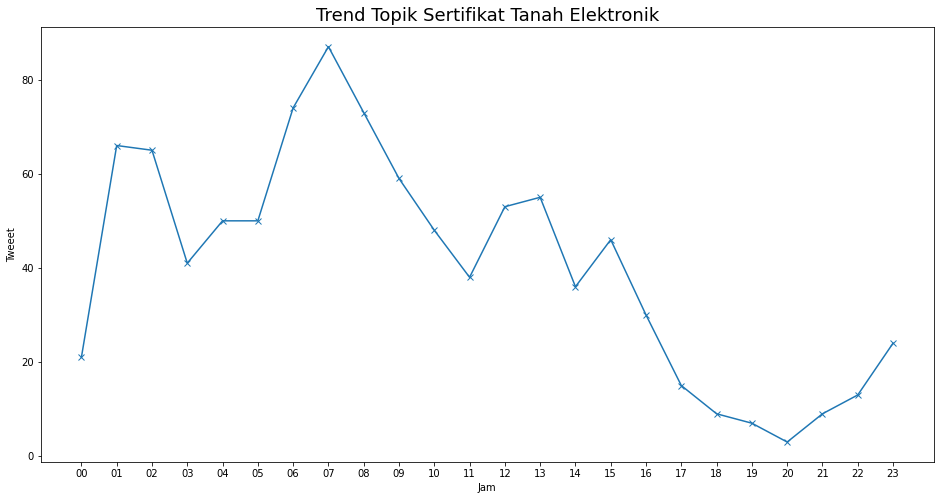

In [26]:
labels, counts = np.unique(sehari, return_counts=True)
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(labels, counts, marker="x")
plt.gca().set_xticks(labels)
plt.ylabel("Tweeet")
plt.xlabel("Jam")
plt.title("Trend Topik Sertifikat Tanah Elektronik", fontsize=18)
plt.show()

In [28]:
jamterbanyak = pd.DataFrame({'jam':labels,'jumlah tweet':counts})
# jamterbanyak = jamterbanyak.sort_values(by=['jumlah tweet'], ascending=False)
jamterbanyak

,jam,jumlah tweet
0,00,21
1,01,66
2,02,65
3,03,41
4,04,50
5,05,50
6,06,74
7,07,87
8,08,73
9,09,59
